# Time Series Scaling

Scaling time series data is an important preprocessing step when using neural forecasting methods for several reasons:

1. **Convergence speed**: Neural forecasting models tend to converge faster when the features are on a similar scale.
2. **Avoiding vanishing or exploding gradients**: some architectures, such as recurrent neural networks (RNNs), are sensitive to the scale of input data. If the input values are too large, it could lead to exploding gradients, where the gradients become too large and the model becomes unstable. Conversely, very small input values could lead to vanishing gradients, where weight updates during training are negligible and the training fails to converge.
3. **Ensuring consistent scale**: Neural forecasting models have shared global parameters for the all time series of the task. In cases where time series have different scale, scaling ensures that no particular time series dominates the learning process.
4. **Improving generalization**: time series with consistent scale can lead to smoother loss surfaces. Moreover, scaling helps to homogenize the distribution of the input data, which can also improve generalization by avoiding out-of-range values.

The `Neuralforecast` library integrates two types of temporal scaling:

* **Time Series Scaling**: scaling each time series using all its data on the train set before start training the model. This is done by using the `local_scaler_type` parameter of the `Neuralforecast` core class.
* **Window scaling (TemporalNorm)**: scaling each input window separetly for each element of the batch at every training iteration. This is done by using the `scaler_type` parameter of each model class.

In this notebook, we will demonstrate how to scale the time series data with both methods on an Eletricity Price Forecasting (EPF) task.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Time_Series_Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install `Neuralforecast`

In [ ]:
%%capture
!pip install neuralforecast
!pip install hyperopt

## 2. Load Data

The `df` dataframe contains the target and exogenous variables past information to train the model. The `unique_id` column identifies the markets, `ds` contains the datestamps, and `y` the electricity price. For future variables, we include a forecast of how much electricity will be produced (`gen_forecast`), system load (`system_laod`), and day of week (`week_day`). Both the electricity system demand and offer impact the price significantly, including these variables to the model greatly improve performance, as we demonstrate in Olivares et al. (2022).

The `futr_df` dataframe includes the information of the future exogenous variables for the period we want to forecast (in this case, 24 hours after the end of the train dataset `df`).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv')
df['ds'] = pd.to_datetime(df['ds'])

futr_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_futr.csv')
futr_df['ds'] = pd.to_datetime(futr_df['ds'])

df.head()

,unique_id,ds,y,gen_forecast,system_load,week_day
0,FR,2015-01-01 00:00:00,53.48,76905.0,74812.0,3
1,FR,2015-01-01 01:00:00,51.93,75492.0,71469.0,3
2,FR,2015-01-01 02:00:00,48.76,74394.0,69642.0,3
3,FR,2015-01-01 03:00:00,42.27,72639.0,66704.0,3
4,FR,2015-01-01 04:00:00,38.41,69347.0,65051.0,3


We can see that `y` and the exogenous variables are on largely different scales. Next, we show two methods to scale the data.

## 3. Time Series Scaling with `Neuralforecast` class

One of the most widely used approches for scaling time series is to treat it as a pre-processing step, where each time series and temporal exogenous variables are scaled based on their entire information in the train set. Models are then trained on the scaled data.

To simplify pipelines, we added a scaling functionality to the `Neuralforecast` class. Each time series will be scaled before training the model with either `fit` or `cross_validation`, and scaling statistics are stored. The class then uses the stored statistics to scale the forecasts back to the original scale before returning the forecasts.

### 3.a. Instantiate model and `Neuralforecast` class

In this example we will use the `TimesNet` model, recently proposed in [Wu, Haixu, et al. (2022)](https://arxiv.org/abs/2210.02186). First instantiate the model with the desired parameters.

In [ ]:
from neuralforecast.models import TimesNet
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
horizon = 24 # day-ahead daily forecast
model = TimesNet(h = horizon,                                                 # Horizon
                 input_size = 5*horizon,                                      # Length of input window
                 max_steps = 100,                                             # Training iterations
                 top_k = 3,                                                   # Number of periods (for FFT).
                 num_kernels = 3,                                             # Number of kernels for Inception module
                 batch_size = 2,                                              # Number of time series per batch
                 windows_batch_size = 32,                                     # Number of windows per batch
                 learning_rate = 0.001,                                       # Learning rate
                 futr_exog_list = ['gen_forecast', 'system_load','week_day'], # Future exogenous variables
                 scaler_type = None)                                          # We use the Core scaling method

Global seed set to 1


Fit the model by instantiating a `NeuralForecast` object and using the `fit` method. The `local_scaler_type` parameter is used to specify the type of scaling to be used. In this case, we will use `standard`, which scales the data to have zero mean and unit variance.Other supported scalers are `minmax`, `robust`, `robust-iqr`, `minmax`, and `boxcox`.

In [ ]:
nf = NeuralForecast(models=[model], freq='H', local_scaler_type='standard')
nf.fit(df=df)

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, v_num=181, train_loss_step=0.413, train_loss_epoch=0.413]


### 3.b Forecast and plots

Finally, use the `predict` method to forecast the day-ahead prices. The `Neuralforecast` class handles the inverse normalization, forecasts are returned in the original scale.

In [ ]:
Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]


,ds,TimesNet
unique_id,,
BE,2016-11-01 00:00:00,33.748502
BE,2016-11-01 01:00:00,32.393269
BE,2016-11-01 02:00:00,29.000997
BE,2016-11-01 03:00:00,26.264737
BE,2016-11-01 04:00:00,28.841827


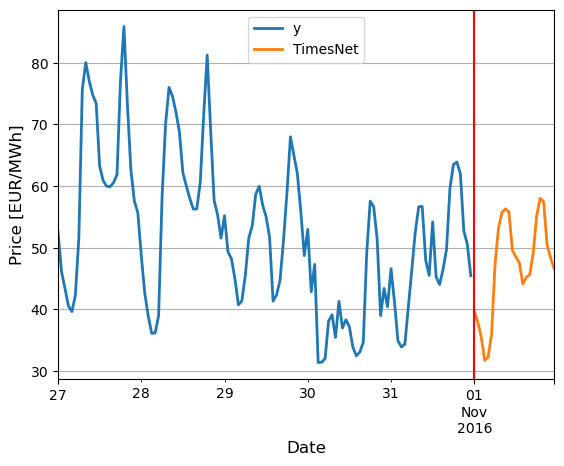

In [ ]:
import matplotlib.pyplot as plt

plot_df = df[df['unique_id']=='FR'].tail(24*5).reset_index(drop=True)
Y_hat_df = Y_hat_df.reset_index(drop=False)
Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='FR']

plot_df = pd.concat([plot_df, Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes

plot_df[['y', 'TimesNet']].plot(linewidth=2)
plt.axvline('2016-11-01', color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid()

:::{.callout-important}
The inverse scaling is performed by the `Neuralforecast` class before returning the final forecasts. Therefore, the hyperparmater selection with `Auto` models and validation loss for early stopping or model selection are performed on the scaled data. Different types of scaling with the `Neuralforecast` class can't be automatically compared with `Auto` models.
:::

## 4. Temporal Window normalization during training

Temporal normalization scales each instance of the batch separately at the window level. It is performed at each training iteration for each window of the batch, for both target variable and temporal exogenous covariates. For more details, see [Olivares et al. (2023)](https://arxiv.org/abs/2305.07089) and https://nixtla.github.io/neuralforecast/common.scalers.html.

### 4.a. Instantiate model and `Neuralforecast` class

Temporal normalization is specified by the `scaler_type` argument. Currently, it is only supported for Windows-based models (`NHITS`, `NBEATS`, `MLP`, `TimesNet`, and all Transformers). In this example, we use the `TimesNet` model and `robust` scaler, recently proposed by Wu, Haixu, et al. (2022). First instantiate the model with the desired parameters.

Visit https://nixtla.github.io/neuralforecast/common.scalers.html for a complete list of supported scalers.

In [ ]:
horizon = 24 # day-ahead daily forecast
model = TimesNet(h = horizon,                                                 # Horizon
                 input_size = 5*horizon,                                      # Length of input window
                 max_steps = 100,                                             # Training iterations
                 top_k = 3,                                                   # Number of periods (for FFT).
                 num_kernels = 3,                                             # Number of kernels for Inception module
                 batch_size = 2,                                              # Number of time series per batch
                 windows_batch_size = 32,                                     # Number of windows per batch
                 learning_rate = 0.001,                                       # Learning rate
                 futr_exog_list = ['gen_forecast', 'system_load','week_day'], # Future exogenous variables
                 scaler_type = 'robust')                                      # Robust scaling

Global seed set to 1


Fit the model by instantiating a `NeuralForecast` object and using the `fit` method. Note that `local_scaler_type` has `None` as default to avoid scaling the data before training.

In [ ]:
nf = NeuralForecast(models=[model], freq='H')
nf.fit(df=df)

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, v_num=183, train_loss_step=0.977, train_loss_epoch=0.977]


### 4.b Forecast and plots

Finally, use the `predict` method to forecast the day-ahead prices. The forecasts are returned in the original scale.

In [ ]:
Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


,ds,TimesNet
unique_id,,
BE,2016-11-01 00:00:00,40.024895
BE,2016-11-01 01:00:00,35.253803
BE,2016-11-01 02:00:00,33.185341
BE,2016-11-01 03:00:00,33.572426
BE,2016-11-01 04:00:00,37.039207


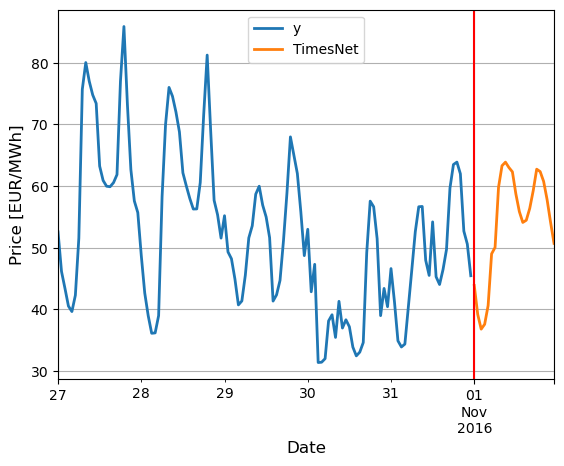

In [ ]:
import matplotlib.pyplot as plt

plot_df = df[df['unique_id']=='FR'].tail(24*5).reset_index(drop=True)
Y_hat_df = Y_hat_df.reset_index(drop=False)
Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='FR']

plot_df = pd.concat([plot_df, Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes

plot_df[['y', 'TimesNet']].plot(linewidth=2)
plt.axvline('2016-11-01', color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid()

:::{.callout-important}
For most applications, models with temporal normalization (section 4) produced more accurate forecasts than time series scaling (section 3). However, with temporal normalization models lose the information of the relative level between different windows. In some cases this global information within time series is crucial, for instance when an exogenous variables contains the dosage of a medication. In these cases, time series scaling (section 3) is preferred.
:::

## References

- [Kin G. Olivares, David Luo, Cristian Challu, Stefania La Vattiata, Max Mergenthaler, Artur Dubrawski (2023). "HINT: Hierarchical Mixture Networks For Coherent Probabilistic Forecasting". International Conference on Machine Learning (ICML). Workshop on Structured Probabilistic Inference & Generative Modeling. Available at https://arxiv.org/abs/2305.07089.](https://arxiv.org/abs/2305.07089)
- [Wu, Haixu, Tengge Hu, Yong Liu, Hang Zhou, Jianmin Wang, and Mingsheng Long. "Timesnet: Temporal 2d-variation modeling for general time series analysis.", ICLR 2023](https://openreview.net/forum?id=ju_Uqw384Oq)